In [5]:
import pandas as pd
import numpy as np
# from numpy import arange
import matplotlib.pyplot as plt
from pandas import read_csv
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
import pickle
from sklearn.preprocessing import MinMaxScaler

In [6]:

# Set 'Date' column as the index
def preprocess_stock_data(csv_file_path):
    # Load data from CSV file
    data = pd.read_csv(csv_file_path)
    data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')
    data.set_index('Date', inplace=True)
    
    # Fill missing dates
    full_date_range = pd.date_range(start=data.index.min(), end=data.index.max(), freq='D')
    data = data.reindex(full_date_range)
    data = data.ffill()
    data.reset_index(inplace=True)
    data.rename(columns={'index': 'Date'}, inplace=True)
    
    # Convert volume from string to number
    def convert_volume_to_number(volume_str):
        if isinstance(volume_str, float) and np.isnan(volume_str):
            return np.nan
        if volume_str[-1] == 'K':
            return int(float(volume_str[:-1]) * 1000)
        elif volume_str[-1] == 'M':
            return int(float(volume_str[:-1]) * 1000000)
        elif volume_str[-1] == 'B':
            return int(float(volume_str[:-1]) * 1000000000)
        else:
            return int(volume_str)
    
    # Apply convert_volume_to_number function to Volume column
    data["Volume"] = data["Volume"].apply(convert_volume_to_number)
    
    # Convert change % from string to number
    def convert_change_to_number(change_str):
        if isinstance(change_str, float) and np.isnan(change_str):
            return np.nan
        new_change = float(change_str.strip('%')) / 100
        return new_change

    # Apply convert_change_to_number function to Change % column
    data["Change %"] = data["Change %"].apply(convert_change_to_number)
    
    # Function to convert string to number
    def convert_str_to_number(str_value):
        if isinstance(str_value, float) and np.isnan(str_value):
            return np.nan
        return float(str_value.replace(',', ''))
    
    # Apply convert_str_to_number function to Close, Open, High, Low columns
    data['Close'] = data['Close'].apply(convert_str_to_number)
    data['Open'] = data['Open'].apply(convert_str_to_number)
    data['High'] = data['High'].apply(convert_str_to_number)
    data['Low'] = data['Low'].apply(convert_str_to_number)
    
    data = data.sort_values('Date', ascending=True)
    return data
data = preprocess_stock_data('../../DATASET/DXG.csv')

In [7]:
data

,Date,Close,Open,High,Low,Volume,Change %
0,2019-03-01,17057.8,16750.2,17057.8,16750.2,1270000,0.0184
1,2019-03-02,17057.8,16750.2,17057.8,16750.2,1270000,0.0184
2,2019-03-03,17057.8,16750.2,17057.8,16750.2,1270000,0.0184
3,2019-03-04,17809.9,17228.8,17878.3,17092.0,5540000,0.0441
4,2019-03-05,17502.2,17775.7,17912.4,17365.5,3490000,-0.0173
...,...,...,...,...,...,...,...
1823,2024-02-26,17850.0,18100.0,18150.0,17650.0,9100000,-0.0165
1824,2024-02-27,18200.0,18000.0,18300.0,17800.0,11250000,0.0196
1825,2024-02-28,18050.0,18300.0,18350.0,18000.0,6990000,-0.0082
1826,2024-02-29,18250.0,18150.0,18400.0,18050.0,13440000,0.0111


In [8]:
X = data[['Open', 'High', 'Low', 'Volume', 'Change %']].values
y = data['Close'].values

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
rf = RandomForestRegressor(n_estimators=10, max_depth=5, max_features=2)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, max_features=2, n_estimators=10)

In [11]:
print(len(X_test))

366


In [12]:

y_pred = rf.predict(X_test)
y_pred

array([13121.21503266, 24682.39389791, 14360.08771027, 43266.53688142,
       34623.76113651,  9211.5038959 , 24113.71582785, 21294.05923527,
       12302.32389426, 12201.4796832 , 26510.62363431, 13121.21503266,
       10423.36841612, 22041.5179439 , 11073.4362916 , 20843.67830718,
       10051.64724901, 34975.41974173, 16706.59796105,  8691.36574763,
       12950.02182858, 18136.21619324,  8024.15146697, 10030.06391567,
       20318.35815674, 14575.5028228 , 19184.11805898, 19402.96937779,
       12201.4796832 , 34794.20452838, 19361.33520154,  8982.08970823,
       10336.04777938, 24592.75564111, 14445.5015154 , 14360.08771027,
       18897.84807889, 13298.75429728, 15171.38221494, 14376.45430175,
       19085.68196201, 40297.94690604, 13422.64714172, 20284.23897737,
       19183.3518318 , 15248.56411484, 14203.05801644, 22044.56716918,
       14221.7079093 , 45766.99844763, 19199.76955644, 21456.78207625,
        8127.96855851,  8604.08717897, 28271.78608059,  8691.36574763,
      

In [13]:
X_train = pd.DataFrame(X_train, index=data.iloc[:len(X_train)].index)
X_test = pd.DataFrame(X_test, index=data.iloc[len(X_train):len(X_train) + len(X_test)].index)
y_train = pd.DataFrame(y_train, index=data.iloc[:len(y_train)].index)
y_test = pd.DataFrame(y_test, index=data.iloc[:len(y_test)].index)
# y_test = pd.Series(y_test, index=data.iloc[len(y_train):len(y_train) + len(y_test)].index)
y_test

,0
0,13391.3
1,26000.0
2,14500.0
3,44000.0
4,35000.0
...,...
361,26500.0
362,24100.0
363,12900.0
364,13200.0


In [14]:
data.index[-1]

1827

In [15]:
future_dates = pd.date_range(start=data[1].index + pd.Timedelta(days=1), periods=90, freq='B')

# Prepare empty dataframe to store predictions
future_data = pd.DataFrame({'Date': future_dates})

# Predict the 'Close' price iteratively for each future date
last_known_data = data.iloc[-1]  # Use the last available historical data for the first prediction

for i, date in enumerate(future_dates):
    features = np.array(last_known_data[['Open', 'High', 'Low', 'Volume', 'Change %']]).reshape(1, -1)
    
    # Predict the 'Close' price for the current date
    future_data.loc[i, 'Close'] = rf.predict(features)
    
    # Update last known data for the next iteration
    last_known_data['Date'] += pd.Timedelta(days=1)
    last_known_data['Close'] = future_data.loc[i, 'Close']

KeyError: 1

Mean Squared Error: 232593.25


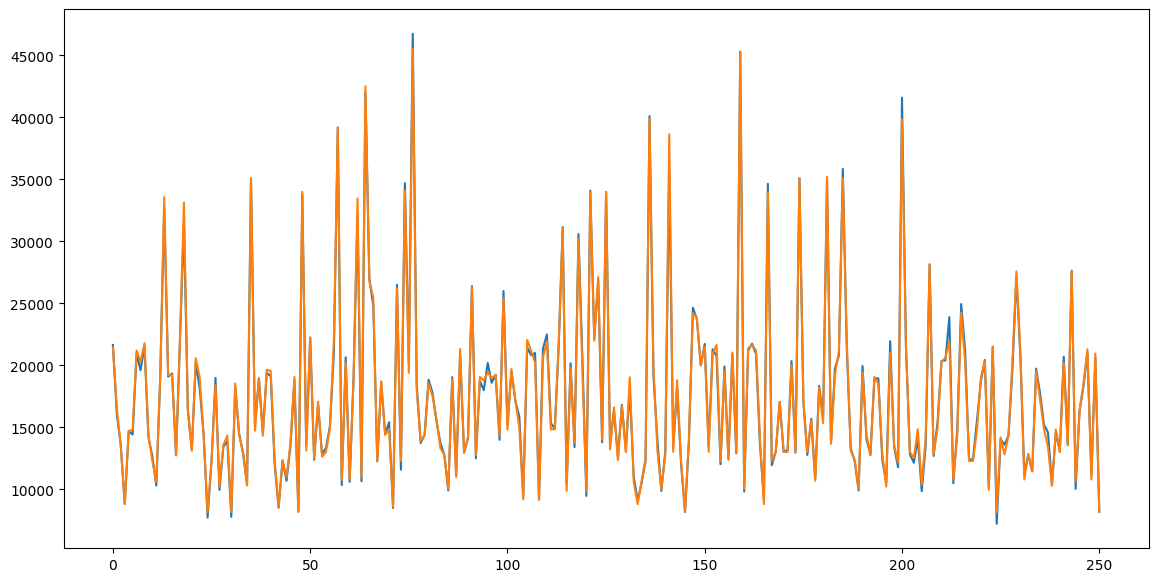